# QAOA - MAXCUT - Randomized Measurements Wire Cutting Experiment 

* Author: Michel Meulen
* Date: 24-04-2025
* Contact: michel.meulen@tno.nl
------------------------------------------------ 

# QAOA Benchmarks Comparison uncut vs wirecut


In the following code is defined how the benchmarks are being run to compare the potential, validation and effect of noise when using wire cutting. Here an uncut and wirecut approach are implemented on three different graphs. Each graphing making it possible to place one more wirecut than the other. 

The following graph use cases have been defined:
1. 2, 3, 2          (Requiring: minimum of 5 qubits and 1 wire cut can be placed)
2. 2, 3, 2, 3       (Requiring: minimum of 5 qubits and 2 wire cuts can be placed)
3. 2, 3, 2, 3, 2    (Requiring: minimum of 5 qubits and 3 wire cuts can be placed)

Multiple backends are being used to simulate the quantum circuitry:

In the first benchmark we compare the results of ideal simulation with the use of Pennylane. We try to examine the effect of wire cutting on the accuracy of the QAOA result.
- Ideal Pennylane Uncut 
- Ideal Pennylane Wirecut

In the second benchmark we compare the results of ideal and noisy simulations with the use of Qiskit's Aer simulator and noise models, provided by IBM Quantum platform, fetched from the quantum device: ibm_brisbane. The main takeaway from this benchmark is the effect of noise on the ability to solve a problem using wire cutting.
- Noisy IBM Brisbane Uncut
- Noisy IBM Brisbane Wirecut

In [1]:
# from wire_cut_qaoa import WireCutQAOA
from graph import Graph
from experiment_configuration import ExperimentConfiguration as ExpConf

from wire_cut_qaoa import WireCutQAOA

from quantum_utils.quantum_utils import QuantumUtils as qu
from quantum_backend import QuantumBackEnd
from results_manager import ResultsManager
from experiment_result import ExperimentResult

# Debug
from quantum_backend import QuantumBackEnd
from wire_cut_circuit import WireCutCircuit
from quantum_channel import QuantumChannel
from quantum_backend import QuantumBackEnd
from quantum_utils.qaoa_utils import QaoaUtils

# Plotting
import matplotlib.pyplot as plt
import numpy as np

FILE_NAME: str = "bin/debug280525.pkl"

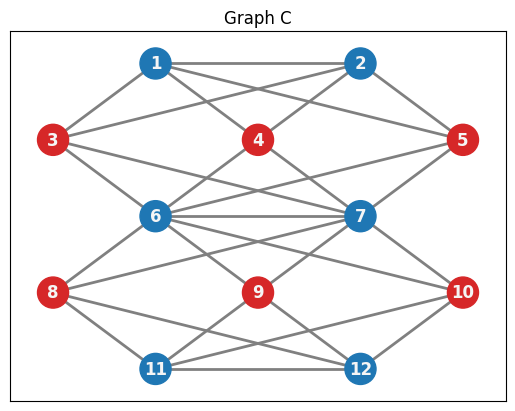

The most optimal solutions for C are: ['001110011100', '110001100011']
The maximum cut is: 24


In [2]:
# 1. Define the benchmarks and their backends
benchmarks: dict = {
    "Pennylane | Uncut": (QuantumBackEnd.PENNYLANE, "Uncut"),                                           # Computational time: Short     
    # "Pennylane | Wire-cut": (QuantumBackEnd.PENNYLANE, "Wirecut"),                                      # Computational time: Medium    
    # "Qiskit Aer | Uncut": (QuantumBackEnd.QISKIT_AER, "Uncut"),	                                        # Computational time: Short
    # "Qiskit Aer | Noisy Uncut Brisbane": (QuantumBackEnd.QISKIT_AER_IBM_BRISBANE, "Uncut"),        # Computational time: Long
    # "Qiskit Aer | Wire-cut": (QuantumBackEnd.QISKIT_AER, "Wirecut"),	                                # Computational time: Medium
    # "Qiskit Aer | Noisy Wire-cut Brisbane": (QuantumBackEnd.QISKIT_AER_IBM_BRISBANE, "Wirecut"),        # Computational time: Long
    # "Qiskit Aer | Noisy Wire-cut Sherbrooke": (QuantumBackEnd.QISKIT_AER_IBM_SHERBROOKE, "Wirecut")   # Computational time: Long
}

# 2. Construct the ResultsManager object storing the benchmarks results
manager: ResultsManager = ResultsManager()

# 3. Construct the three different graphs
graphs: dict = {
    # "Graph A": Graph([2, 3, 2], "A"),
    # "Graph B": Graph([2, 3, 2, 3], "B"),
    "Graph C": Graph([2, 3, 2, 3, 2], "C"),
}

[graph.Visualise(key) for key, graph in graphs.items()]

# 4. Setup the configuration file, important to note is the amount of shots here and sample size.
configDict: dict = {
    "experimentName": "Effect of wire-cutting QAOA-MAXCUT compared to ideal and noisy simulations",
    "numQaoaLayers": 1,
    "shotsBudgetPerQuantumCircuit": 2000,
    "numSamples": 50,
    "maxClassicalOptimizationIterations": 5, # Arbitrary number, but should be high enough to allow for convergence and limit the amount of shots being used.
    "totalMaxShots": 2000 * 150, # Both uncut and wire-cut benchmark have access to the same amount of shots.
    "classicalOptimizationAlgorithm": "SPSA"
}

config: ExpConf = ExpConf(configDict)

In [3]:
# 5. Execute each benchmark
for benchmarkName, benchmark in benchmarks.items():

    for graphName, graph in graphs.items():
        experimentName = f"{benchmarkName} | {graphName}"
        print(f"Running experiment: {experimentName}") 

        config.SetName(experimentName)

        if benchmark[1] == "Uncut":
            exp = WireCutQAOA(graph=graph, config=config)
            results: list = exp.RunUncut(benchmark[0])
        else:
            exp = WireCutQAOA(graph=graph, config=config)
            results: list = exp.RunWireCut(benchmark[0])

        manager.AddResults(experimentName, results)
        # qu.ProbabilitesToBarChart(results[0].GetProbs(), benchmarkName, f"Final Probabilities {experimentName}", verticalLog=False)
        # results[0].PlotCostHistory()
        # print("Highest probability is binary state: ", max(results[0].GetCounts(), key=results[0].GetCounts().get))
        # print("Highest merged probability is binar: ", max(QaoaUtils.MergeInverses(results[0].GetCounts()), key=QaoaUtils.MergeInverses(results[0].GetCounts()).get))
        # print(results[0].config)
        manager.WriteToBinaryFile(FILE_NAME)

Running experiment: Pennylane | Uncut | Graph C


IntProgress(value=0, bar_style='info', description='Running Uncut QAOA Circuit', max=50)

Benchmark: Pennylane | Uncut | Graph C
	Approximation Ratio: 0.6373912500000001
	Success Probabilities: {'Best': 0.72, 'Second Best': 0.02, 'Third Best': 0.08, 'Wrong': 0.18}



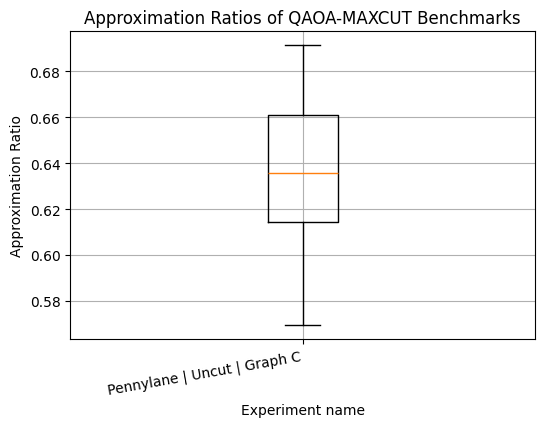

In [4]:
# 6. Read manager object from binary file in bin directory
manager = ResultsManager.FromBinaryFile(FILE_NAME)

store: list = []
labels: list[str] = []
data: list[list] = []

# store.append(manager.GetAllForGraph("Graph A"))
# store.append(manager.GetAllForGraph("Graph B"))
store.append(manager.GetAllForGraph("Graph C"))

for graphScenario in store:
    for benchmark in graphScenario:
        labels.append(benchmark.name)
        data.append(benchmark.GetApproximationRatios())
        print(benchmark)
    
    # Create the boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(data, tick_labels=labels)

    # Add labels and title
    plt.xlabel('Experiment name')
    plt.ylabel('Approximation Ratio')
    plt.title('Approximation Ratios of QAOA-MAXCUT Benchmarks')
    plt.xticks(rotation=10, ha='right')

    # Add grid for better readability
    plt.grid(True)

    # Show the plot
    plt.show()

    labels = []; data = []

# Pennylane Results | Ideal 

These results are obtained using Pennylane where the uncut circuits consist of 120 samples and the wirecut circuits consist of 60 samples. 

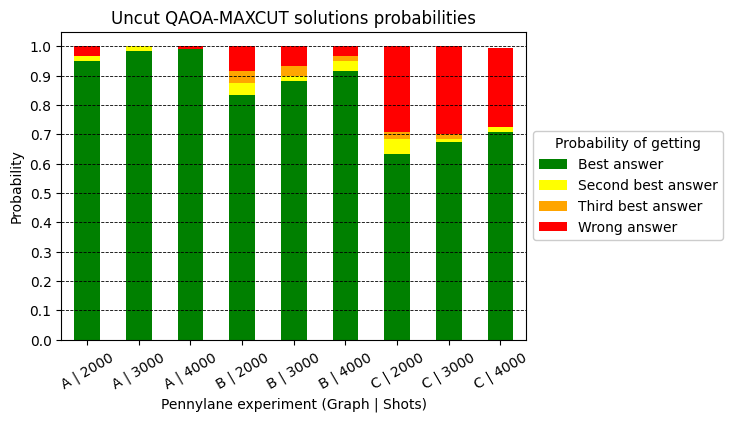

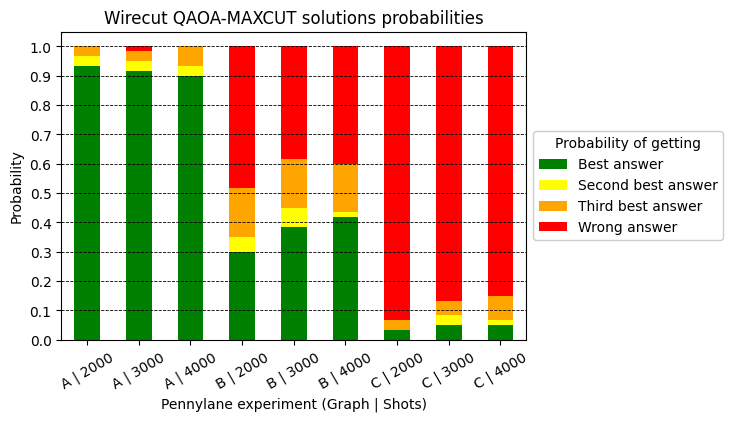

In [5]:
import pandas as pd

labels: list = [
    "Best answer",
    "Second best answer",
    "Third best answer",
    "Wrong answer"
]

colours: dict = {
    "Best answer" : "Green",
    "Second best answer": "Yellow",
    "Third best answer" : "Orange",
    "Wrong answer" : "Red"
}

yTicks = np.arange(0, 1.1, 0.1).tolist() # 1.1 to include 1.0

# === [PROBABILITIES] ===
# Data uncut based on 120 samples
pennylaneGraphAdataUncut: list[list] = [
    ["A | 2000", 0.95, 0.0167, 0.0, 0.0333],
    ["A | 3000", 0.9833, 0.0167, 0.0, 0.0],
    ["A | 4000", 0.9917, 0.0, 0.0, 0.0083],
]

pennylaneGraphBdataUncut: list[list] = [
    ["B | 2000", 0.8333, 0.0416, 0.0416, 0.0833],
    ["B | 3000", 0.8833, 0.0167, 0.0333, 0.0667],
    ["B | 4000", 0.9167, 0.0333, 0.0167, 0.0333],
]

pennylaneGraphCdataUncut: list[list] = [
    ["C | 2000", 0.6333, 0.05, 0.025, 0.2917],
    ["C | 3000", 0.675, 0.0083, 0.0167, 0.3],
    ["C | 4000", 0.7083, 0.0167, 0.0008, 0.2666],
]

# Data based on wire cut on 60 samples
pennylaneGraphAdataWirecut: list[list] = [
    ["A | 2000", 0.9333, 0.0333, 0.0333, 0.0],
    ["A | 3000", 0.9167, 0.0333, 0.0333, 0.0167],
    ["A | 4000", 0.9, 0.0333, 0.0667, 0.0]
]

pennylaneGraphBdataWirecut: list[list] = [
    ["B | 2000", 0.3, 0.05, 0.1667, 0.4833],
    ["B | 3000", 0.3833, 0.0667, 0.1667, 0.3833],
    ["B | 4000", 0.4167, 0.0167, 0.1667, 0.4]
]

pennylaneGraphCdataWirecut: list[list] = [
    ["C | 2000", 0.0333, 0.0, 0.0333, 0.9333],
    ["C | 3000", 0.05, 0.033, 0.05, 0.8667],
    ["C | 4000", 0.05, 0.0167, 0.0833, 0.85]
]

pennylaneWireCutData = pd.DataFrame(pennylaneGraphAdataWirecut + pennylaneGraphBdataWirecut + pennylaneGraphCdataWirecut, columns=["Pennylane experiment (Graph | Shots)"] + labels)	
pennylaneUncutData = pd.DataFrame(pennylaneGraphAdataUncut + pennylaneGraphBdataUncut + pennylaneGraphCdataUncut, columns=["Pennylane experiment (Graph | Shots)"] + labels)	

pennylaneUncutData.plot.bar(x="Pennylane experiment (Graph | Shots)", stacked=True, figsize=(6, 4), color=colours, title="Uncut QAOA-MAXCUT solutions probabilities", ylabel="Probability", rot=30, yticks=yTicks)
plt.legend(framealpha=1, title="Probability of getting", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid(True, axis='y', color="black", linestyle='--', linewidth=0.6)

pennylaneWireCutData.plot.bar(x="Pennylane experiment (Graph | Shots)", stacked=True, figsize=(6, 4), color=colours, title="Wirecut QAOA-MAXCUT solutions probabilities", ylabel="Probability", rot=30, yticks=yTicks)
plt.legend(framealpha=1, title="Probability of getting", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid(True, axis='y', color="black", linestyle='--', linewidth=0.6)


# labels = list(pennylaneApproxUncut.keys())
# valuesUncut = list(pennylaneApproxUncut.values())
# valuesWirecut = list(pennylaneApproxWirecut.values())


# qu.CustomPlot(["Uncut", "Wirecut"], labels, [valuesUncut, valuesWirecut])

plt.show()

# Qiskit Aer Results | Ideal & Noisy

These results are gathered using the qiskit aer simulator. This backend makes it possible to run noisy simulations based on the quantum machines provided by IBMQ platform. In the following benchmarks the brisbane noise model is being used.

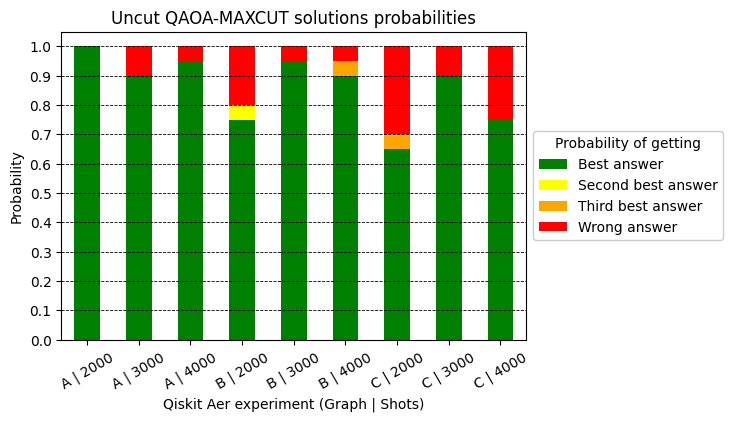

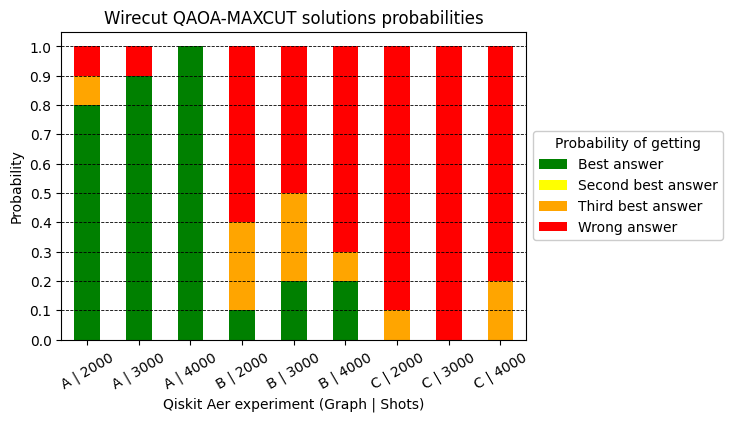

In [6]:
# Averages over [ideal: 50, noisy: 25] samples 2000 shots Qiskit AER ideal and noisy simulations
qiskitGraphANoisyBrisbaneUncut: list[list] = [
    ["A | 2000", 1.0, 0.0, 0.0, 0.0],
    ["A | 3000", 0.9, 0.0, 0.0, 0.1],
    ["A | 4000", 0.95, 0.0, 0.0, 0.05]
]

qiskitGraphBNoisyBrisbaneUncut: list[list] = [
    ["B | 2000", 0.75, 0.05, 0.0, 0.2],
    ["B | 3000", 0.95, 0.0, 0.0, 0.05],
    ["B | 4000", 0.9, 0.0, 0.05, 0.05]
]

qiskitGraphCNoisyBrisbaneUncut: list[list] = [
    ["C | 2000", 0.65, 0.0, 0.05, 0.3],
    ["C | 3000", 0.9, 0.0, 0.0, 0.1],
    ["C | 4000", 0.75, 0.0, 0.0, 0.25]
]


qiskitGraphANoisyBrisbaneWirecut: list[list] = [
    ["A | 2000", 0.8, 0.0, 0.1, 0.1],
    ["A | 3000", 0.9, 0.0, 0.0, 0.1],
    ["A | 4000", 1.0, 0.0, 0.0, 0.0]
]

qiskitGraphBNoisyBrisbaneWirecut: list[list] = [
    ["B | 2000", 0.1, 0.0, 0.3, 0.6],
    ["B | 3000", 0.2, 0.0, 0.3, 0.5],
    ["B | 4000", 0.2, 0.0, 0.1, 0.7]
]

qiskitGraphCNoisyBrisbaneWirecut: list[list] = [
    ["C | 2000", 0.0, 0.0, 0.1, 0.9],
    ["C | 3000", 0.0, 0.0, 0.0, 1.0],
    ["C | 4000", 0.0, 0.0, 0.2, 0.8]
]

pennylaneWireCutData = pd.DataFrame(qiskitGraphANoisyBrisbaneWirecut + qiskitGraphBNoisyBrisbaneWirecut + qiskitGraphCNoisyBrisbaneWirecut, columns=["Qiskit Aer experiment (Graph | Shots)"] + labels)	
pennylaneUncutData = pd.DataFrame(qiskitGraphANoisyBrisbaneUncut + qiskitGraphBNoisyBrisbaneUncut + qiskitGraphCNoisyBrisbaneUncut, columns=["Qiskit Aer experiment (Graph | Shots)"] + labels)	

pennylaneUncutData.plot.bar(x="Qiskit Aer experiment (Graph | Shots)", stacked=True, figsize=(6, 4), color=colours, title="Uncut QAOA-MAXCUT solutions probabilities", ylabel="Probability", rot=30, yticks=yTicks)
plt.legend(framealpha=1, title="Probability of getting", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid(True, axis='y', color="black", linestyle='--', linewidth=0.6)

pennylaneWireCutData.plot.bar(x="Qiskit Aer experiment (Graph | Shots)", stacked=True, figsize=(6, 4), color=colours, title="Wirecut QAOA-MAXCUT solutions probabilities", ylabel="Probability", rot=30, yticks=yTicks)
plt.legend(framealpha=1, title="Probability of getting", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid(True, axis='y', color="black", linestyle='--', linewidth=0.6)

plt.show()
